In [1]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/hl/t7z2ty39543bkmkmkphsh1c00000gn/T/pip-req-build-6p5faouc
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /private/var/folders/hl/t7z2ty39543bkmkmkphsh1c00000gn/T/pip-req-build-6p5faouc
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

from sklearn.model_selection import train_test_split

In [3]:
def load(image_path):
    img = tf.io.read_file(image_path)
    if image_path.endswith(".jpg"):
        img = tf.image.decode_jpeg(img)
    else:
        img = tf.image.decode_png(img)
        img = img[..., :3]

    if img.shape[-1] == 1:
        img = tf.concat([img, img, img], axis=-1)

    img = tf.image.resize(img, (256, 256))

    img = tf.cast(img, tf.float32)
    
    return img

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
skeleton_data = []
animal_data = []

skel_folder_path = os.path.join('dataset/skeletons')
for img_file in os.listdir(skel_folder_path):
    img_path = os.path.join(skel_folder_path, img_file)
    img = load(img_path)
    skeleton_data.append(img)

folder_path = os.path.join('dataset/animal')
for img_file in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_file)
    img = load(img_path)
    animal_data.append(img)

# 75% train, 25% test
skel_train, skel_test, animl_train, animl_test = train_test_split(skeleton_data, animal_data, test_size=0.25, random_state=42)

2024-04-10 15:32:34.263449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 15:32:34.263472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-04-10 15:32:35.685573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 15:32:35.685596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-04-10 15:32:35.934923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 15:32:35.934945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [7]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [8]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [9]:
def preprocess_image_train(image, label=0):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
def preprocess_image_test(image, label=1):
  image = normalize(image)
  return image

In [11]:
train_skel_ds = tf.data.Dataset.from_tensor_slices(skel_train)
train_animl_ds = tf.data.Dataset.from_tensor_slices(animl_train)
test_skel_ds = tf.data.Dataset.from_tensor_slices(skel_test)
test_animl_ds = tf.data.Dataset.from_tensor_slices(animl_test)

In [12]:
train_skel_ds = train_skel_ds.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_animl_ds = train_animl_ds.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_skel_ds = test_skel_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_animl_ds = test_animl_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
sample_skel = next(iter(train_skel_ds))
sample_animl = next(iter(train_animl_ds))

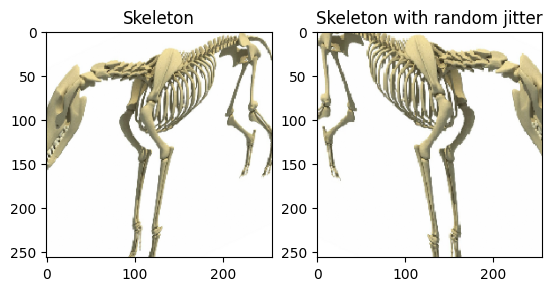

In [14]:
plt.subplot(121)
plt.title('Skeleton')
plt.imshow(sample_skel[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Skeleton with random jitter')
plt.imshow(random_jitter(sample_skel[0]) * 0.5 + 0.5)

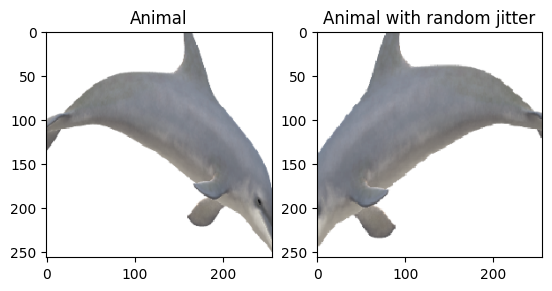

In [15]:
plt.subplot(121)
plt.title('Animal')
plt.imshow(sample_animl[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Animal with random jitter')
plt.imshow(random_jitter(sample_animl[0]) * 0.5 + 0.5)